In [1]:
import torch
import matplotlib.pyplot as plt
from torch import distributions
import seaborn as sns
import numpy as np
import torch
import torch.nn as nn
from tqdm.auto import tqdm
import matplotlib as mpl
mpl.rcParams['font.size'] = 14

torch.manual_seed(42)
np.random.seed(42)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

from network import ClassifierNN,load_model_info
from density_utils import draw_density_ratio, refine_sample, refine_sample2, draw_density_ratio2, draw_density_ratio_GP, refine_sample_GP, refine_sample2_GP

from utils import load_item, show_grasp, count_real_positives
from dataset import ToyGraspDataset

%load_ext autoreload
%autoreload 2

# GP Classifier Sim+ vs Real+

In [2]:
import torch
import matplotlib.pyplot as plt
from torch import distributions
import seaborn as sns
import numpy as np
import torch
import torch.nn as nn
from tqdm.auto import tqdm
import matplotlib as mpl
mpl.rcParams['font.size'] = 14

torch.manual_seed(42)
np.random.seed(42)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

from network import ClassifierNN, train_network, save_model_info, load_model_info

from density_utils import draw_density_ratio, refine_sample, refine_sample2, draw_density_ratio2, refine_sample_GP, draw_density_ratio_GP

from utils import load_item, show_grasp
from dataset import ToyGraspDataset

from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim

torch.manual_seed(42)


sim2real!!!


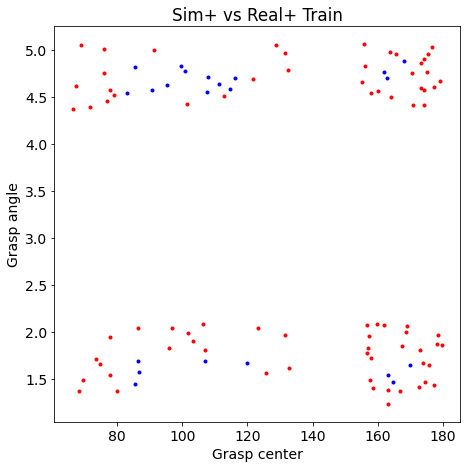

In [3]:
# USING 2D FORK DATA ===============================

n = 10

# train classifier
train_dataset = ToyGraspDataset(root='data', name='sim2real_train', size=100, is_pos_label=True, device=device)
train_dataloader = DataLoader(train_dataset, batch_size=512, shuffle=True)

test_dataset = ToyGraspDataset(root='data', name='sim2real_test', size=n, is_pos_label=True, device=device)
test_dataloader = DataLoader(test_dataset, batch_size=512, shuffle=False)



# dataset = ToyGraspDataset(root='data', size=50)
train_x = torch.Tensor(train_dataset.data[:,:2])
train_y = torch.Tensor(train_dataset.data[:,2]).long()
x_t = train_x.clone()
# Normalize inputs
x_t[:,0] /= 244
x_t[:,1] /= (3.14*2)

x_t = x_t.repeat(1,200)



# y = train_dataset.data[:,2].reshape(-1,1)

# test_x = torch.Tensor(test_dataset.data[:,:2])
# # test_x = torch.Tensor(test_dataset.data[:,:2])
# test_x_mat = torch.reshape(test_x[:,0], (n, n))
# test_y_mat = torch.reshape(test_x[:,1], (n, n))

# test_y = torch.Tensor(test_dataset.data[:,2]).long()
# test_labels = torch.reshape(test_y, (n, n))





fig = plt.figure(figsize=(16,16))
ax1 = fig.add_subplot(221)

# show the data
data = train_dataset.data
pos_masks = data[:,2] == 1
neg_masks = ~pos_masks

ax1.scatter(data[pos_masks][:,0], data[pos_masks][:,1], marker='.', alpha=1.0, color='b')
ax1.scatter(data[neg_masks][:,0], data[neg_masks][:,1], marker='.', alpha=1.0, color='r')
ax1.set_title('Sim+ vs Real+ Train')
ax1.set_xlabel('Grasp center')
ax1.set_ylabel('Grasp angle')





# ax2 = fig.add_subplot(222)
# test_pos_masks = test_y == 1
# test_neg_masks = ~test_pos_masks

# ax2.scatter(test_x[test_pos_masks][:,0], test_x[test_pos_masks][:,1], marker='.', alpha=1.0, color='b')
# ax2.scatter(test_x[test_neg_masks][:,0], test_x[test_neg_masks][:,1], marker='.', alpha=1.0, color='r')
# ax2.set_title('Sim+ vs Real+ Test')
# ax2.set_xlabel('Grasp center')
# ax2.set_ylabel('Grasp angle')



plt.show()

In [4]:
x_t.size()

torch.Size([100, 400])

In [5]:
import math
import torch
import numpy as np
import gpytorch
from matplotlib import pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

from gpytorch.models import ExactGP
from gpytorch.likelihoods import DirichletClassificationLikelihood
from gpytorch.means import ConstantMean
from gpytorch.kernels import ScaleKernel, RBFKernel

from network import ExactGPModel



likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(x_t, train_y, likelihood)

# this is for running the notebook in our testing framework
import os
smoke_test = ('CI' in os.environ)
training_iter = 2 if smoke_test else 100


# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = likelihood(model(x_t))
#     print(output.loc[:10])
    
    # Calc loss and backprop gradients
#     loss = -mll(output, likelihood.transformed_targets).sum()
    loss = -mll(output, train_y).sum()
#     loss = -mll(output, ytrain_tensor)

    loss.backward()

#     train_accuracy = (torch.round(output.loc.clone()) == train_y).sum().item()
    
    if i % 10 == 0:

        print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
            i + 1, training_iter, loss.item(),
            model.covar_module.base_kernel.lengthscale.item(),
            model.likelihood.noise.item()
        ))        
#         print('Iter %d/%d - Loss: %.3f - Acc: %.3f' % (i + 1, training_iter, loss.item(), train_accuracy))
#         print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iter, loss.item()))
    optimizer.step()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Iter 1/100 - Loss: 1.252   lengthscale: 0.693   noise: 0.693
Iter 11/100 - Loss: 0.881   lengthscale: 1.287   noise: 0.312
Iter 21/100 - Loss: 0.587   lengthscale: 1.836   noise: 0.128
Iter 31/100 - Loss: 0.511   lengthscale: 1.848   noise: 0.061
Iter 41/100 - Loss: 0.484   lengthscale: 1.145   noise: 0.052
Iter 51/100 - Loss: 0.429   lengthscale: 0.485   noise: 0.056
Iter 61/100 - Loss: 0.405   lengthscale: 0.320   noise: 0.043
Iter 71/100 - Loss: 0.375   lengthscale: 0.395   noise: 0.029
Iter 81/100 - Loss: 0.359   lengthscale: 0.318   noise: 0.021
Iter 91/100 - Loss: 0.353   lengthscale: 0.305   noise: 0.017


In [6]:
steps_refinement = 100


# from the GP classifier
# f2
# Nq = info2['pos_samples_size'], Np = info2['neg_samples_size']

Nq = int(train_y.sum())
Np = int(train_y.size()[0] - train_y.sum())

# print(my_sample)
# my_sample = torch.FloatTensor([[25, 0.3],
my_sample = torch.FloatTensor([[60, 1.5],
                               [210, 3]])#[160, 3]
# my_sample = torch.FloatTensor([[210, 3]])

my_sample[:,0] /= 224
my_sample[:,1] /= (2*3.14)

my_sample = my_sample.repeat(1,200)

model.to(device)
model.eval()
likelihood.to(device)
likelihood.eval()

all_x1, all_v1 = refine_sample_GP(my_sample.to(device), model, likelihood, steps=steps_refinement,
# all_x1, all_v1 = refine_sample_GP(my_sample.to(device), model, steps=steps_refinement,
#                                eta=0.0001, noise_factor=0.0000,
                               eta=0.1, noise_factor=0.000,
#                                eta=0.5, noise_factor=0.000,
                              Nq = Nq, Np = Np)

22 78
22 78


  0%|          | 0/100 [00:00<?, ?it/s]

In [7]:
# train_x
# all_x1
my_sample.size()

torch.Size([2, 400])

  0%|          | 0/10 [00:00<?, ?it/s]

0.40268606 0.82953876


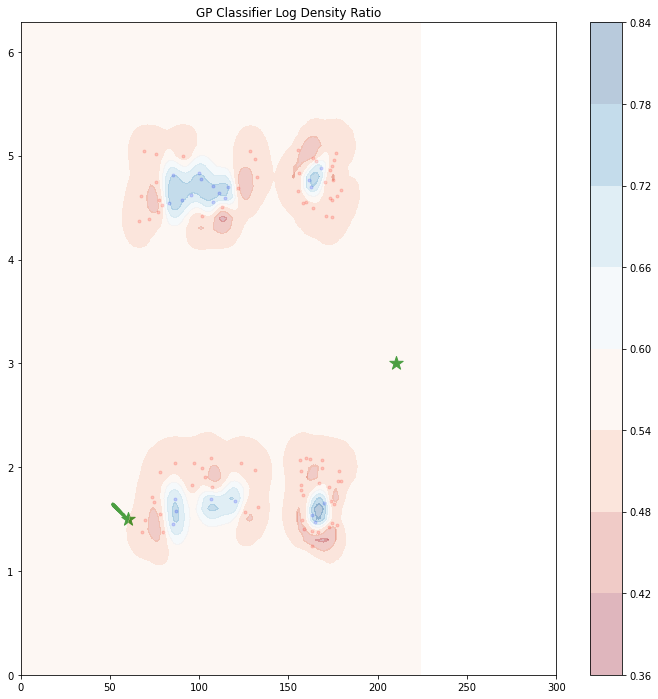

In [9]:
import torch
torch.cuda.empty_cache()
fig, ax = plt.subplots(nrows=1, figsize=(12,12))
ax.scatter(train_x[pos_masks][:,0], train_x[pos_masks][:,1], marker='.', alpha=0.2, color='b')
ax.scatter(train_x[neg_masks][:,0], train_x[neg_masks][:,1], marker='.', alpha=0.2, color='r')

plt.scatter(my_sample[:, 0]*224, my_sample[:,1]*(2*3.14), marker='*', color='g', s=200)
# plt.scatter(my_sample[:, 0], my_sample[:,1], marker='*', color='g', s=200)

for i in range(1, steps_refinement, 1):
    plt.scatter(all_x1[i][:, 0]*224, all_x1[i][:,1]*(2*3.14), marker='d', color='g', s=4)
#     plt.scatter(all_x1[i][:, 0], all_x1[i][:,1], marker='d', color='g', s=4)


Z, CS = draw_density_ratio_GP(ax=ax,
                   model=model,
                   likelihood=likelihood,
                   p_type='p_y_given_x',
#                    p_type='log_density_ratio',
                   device=device,
                   x_lim=[0, 224],
                   y_lim=[0, 2*np.pi],
                   cmap='RdBu',
                   step_size=0.1,
                   Np=Np, Nq=Nq)
fig.colorbar(CS, ax=ax)



ax.set_title(f'GP Classifier Log Density Ratio')
ax.set_xlim([0, 300])
ax.set_ylim([0, 2*np.pi])

plt.show()

# Refining Multiple Grasps

1. Create test dataset
2. Refine datapoints
    - using single refinement
    - using corrector refinement
3. create graph/table

In [ ]:
from dataset import ToyGraspDataset
# real_dataset = ToyGraspDataset(root='data', size=10000, is_pos_label=True, device=device)
real_dataset = ToyGraspDataset(root='data', name='real_refine', size=200, is_pos_label=True, device=device)

# show the data
real_data = real_dataset.data
real_pos_masks = real_data[:,2] == 1
real_neg_masks = ~real_pos_masks


fig = plt.figure(figsize=(6,6))
ax1 = fig.add_subplot(111)

ax1.scatter(real_data[real_pos_masks][:,0], real_data[real_pos_masks][:,1], marker='.', alpha=1.0, color='b')
ax1.scatter(real_data[real_neg_masks][:,0], real_data[real_neg_masks][:,1], marker='.', alpha=1.0, color='r')
ax1.set_title('Real+ vs Real-')
ax1.set_xlabel('Grasp center')
ax1.set_ylabel('Grasp angle')

plt.show()

real_data = torch.tensor(real_data[:,:2])
real_data[:,0] /= 224
real_data[:,1] /= (2*3.14)

all_data = {}

In [ ]:
# load pos vs neg classifier
f1 = ClassifierNN([2, 64, 64, 1])
f1, info1 = load_model_info('pos_vs_neg', f1)
f1 = f1.to(device)
all_data['f1'] = f1
all_data['info1'] = info1

In [ ]:
# load sim+ vs sim- classifier
f2 = ClassifierNN([2, 32, 32, 1])
f2, info2 = load_model_info('sim_vs_real_1k', f2)
# f2, info2 = load_model_info('sim_vs_real_2.5k', f2)
# f2, info2 = load_model_info('sim_vs_real_1k', f2)
f2 = f2.to(device)
all_data['f2'] = f2
all_data['info2'] = info2

In [ ]:
f4 = model
info4={}
info4['pos_samples_size'] = Nq
info4['neg_samples_size'] = Np
all_data['f4'] = f4
all_data['info4'] = info4

In [ ]:
# set refinement parameters
f_div = 'KL'
steps_refinement = 100

## Classifier Refinement

In [ ]:
all_x1, all_v1 = refine_sample(real_data.to(device), f1, steps=steps_refinement, f=f_div,
                               eta=0.00001, noise_factor=0.001,
                              Nq = info1['pos_samples_size'], Np = info1['neg_samples_size'])

refined_points = all_x1[-1].clone()
refined_points[:,0] *= 224
refined_points[:,1] *= (2*3.14)*(180/np.pi)

n_orig_pos = np.sum(real_pos_masks)
n_refined_pos, pos_mask = count_real_positives(refined_points)

all_data['all_x1'] = all_x1
all_data['all_v1'] = all_v1
all_data['n_orig_pos'] = n_orig_pos
all_data['n_pos_1'] = n_refined_pos
all_data['pos_mask_1'] = pos_mask


print(n_orig_pos)
print(n_refined_pos)

## NN Corrector Refinement 

In [ ]:
all_x2, all_v2 = refine_sample(real_data.to(device), f2, steps=steps_refinement, f=f_div,
                               eta=0.0001, noise_factor=0.0000,
                              Nq = info2['pos_samples_size'], Np = info2['neg_samples_size'])
refined_points = all_x2[-1].clone()
refined_points[:,0] *= 224
refined_points[:,1] *= (2*3.14)*(180/np.pi)

n_refined_pos, pos_mask = count_real_positives(refined_points)
all_data['pos_mask_2'] = pos_mask

all_data['all_x2'] = all_x2
all_data['all_v2'] = all_v2
all_data['n_pos_2'] = n_refined_pos

print(n_orig_pos)
print(n_refined_pos)

## Classifier + NN Corrector Refinement

In [ ]:
all_x3, all_v3 = refine_sample2(real_data.to(device), f1, f2,
                                steps=steps_refinement,
#                                 steps=150,
                                f=f_div,
                                eta=0.00004,
                                noise_factor=0.000,
                                Np1=info['neg_samples_size'],
                                Nq1=info['pos_samples_size'],
                                Np2=info2['neg_samples_size'],
                                Nq2=info2['pos_samples_size']
                                )
# all_x8 = torch.cat(all_x8).numpy()

refined_points = all_x3[-1].clone()
refined_points[:,0] *= 224
refined_points[:,1] *= (2*3.14)*(180/np.pi)

n_refined_pos, pos_mask = count_real_positives(refined_points)
all_data['pos_mask_3'] = pos_mask
all_data['all_x3'] = all_x3
all_data['all_v3'] = all_v3
all_data['n_pos_3'] = n_refined_pos

print(n_orig_pos)
print(n_refined_pos)

## GP Corrector Refinement

In [ ]:
all_x_GC, all_v_GC = refine_sample_GP(real_data.to(device), f4, likelihood,
                                steps=steps_refinement,
#                                 steps=150,
                                f=f_div,
                                eta=0.00004,
                                noise_factor=0.000,
                                Np=info3['neg_samples_size'],
                                Nq=info3['pos_samples_size'],
                                )
# all_x8 = torch.cat(all_x8).numpy()

refined_points = all_x_GC[-1].clone()
refined_points[:,0] *= 224
refined_points[:,1] *= (2*3.14)*(180/np.pi)

n_refined_pos, pos_mask = count_real_positives(refined_points)
all_data['pos_mask_4'] = pos_mask
all_data['likelihood'] = likelihood
all_data['all_x4'] = all_x_GP
all_data['all_v4'] = all_v_GP
all_data['n_pos_4'] = n_refined_pos

print(n_orig_pos)
print(n_refined_pos)

## Classifier + GP Corrector Refinement

In [ ]:
f4 = model
info4={}
info4['pos_samples_size'] = Nq
info4['neg_samples_size'] = Np
all_x_GP, all_v_GP = refine_sample2_GP(real_data.to(device), f1, f4, likelihood,
                                steps=steps_refinement,
#                                 steps=150,
                                f=f_div,
                                eta=0.00004,
                                noise_factor=0.000,
                                Np1=info['neg_samples_size'],
                                Nq1=info['pos_samples_size'],
                                Np2=info3['neg_samples_size'],
                                Nq2=info3['pos_samples_size']
                                )
# all_x8 = torch.cat(all_x8).numpy()

refined_points = all_x_GP[-1].clone()
refined_points[:,0] *= 224
refined_points[:,1] *= (2*3.14)*(180/np.pi)

n_refined_pos, pos_mask = count_real_positives(refined_points)
all_data['pos_mask_5'] = pos_mask

all_data['all_x5'] = all_x_GP
all_data['all_v5'] = all_v_GP
all_data['n_pos_5'] = n_refined_pos


print(n_orig_pos)
print(n_refined_pos)

In [ ]:
all_data.keys()

In [ ]:
colors = ['b','g','r','c','m','y','k','w']
titles = ['',
          'NN',
          'NN Corrector',
          'NN + NN Corrector',
          'GP Corrector',
          'NN + GP Corrector'
         ]

fig = plt.figure(figsize=(10,50))

for a in range(1,6):
    ax = fig.add_subplot(int(f'51{a}'))

    fig.colorbar(CS, ax=ax)
    ax.set_xlim([0, 224])
    ax.set_ylim([0, 2*np.pi])
                         
    pos_mask = all_data[f'pos_mask_{a}']
#     neg_mask = ~pos_mask
                         
    for i in range(50):
#     for i in range(real_data.size(0)):

#     if a!=5:
#         if pos_mask[i]==True:
#             ax.scatter(all_data[f'all_x{a}'][-1][i, 0]*224, all_data[f'all_x{a}'][-1][i,1]*(2*3.14), marker='o', color='b', s=10)
#         else:
#             ax.scatter(all_data[f'all_x{a}'][-1][i, 0]*224, all_data[f'all_x{a}'][-1][i,1]*(2*3.14), marker='o', color='r', s=10)
#     else:
        for j in range(1, steps_refinement, 5):
            if pos_mask[i]==True:
                ax.scatter(all_data[f'all_x{a}'][j][i, 0]*224, all_data[f'all_x{a}'][j][i,1]*(2*3.14), marker='o', color='b', s=10)
            else:
                ax.scatter(all_data[f'all_x{a}'][j][i, 0]*224, all_data[f'all_x{a}'][j][i,1]*(2*3.14), marker='o', color='r', s=10)

#     info = None
    
    if a<3:
        f = all_data[f'f{a}']
        info = all_data[f'info{a}']
    elif a == 3:
        f = all_data['f2']
        info = all_data['info2']
    elif a>=4:
        f = all_data['f4']
        info = all_data['info4']             
                         
    if a < 4:
        Z, CS = draw_density_ratio(ax=ax,
                           model=f,
        #                    p_type='log_density_ratio',
                           p_type='p_y_given_x',
                           device=device,
                           x_lim=[0, 224],
                           y_lim=[0, 2*np.pi],
                           cmap='RdBu',
                           step_size=0.05,
                           Np=info['neg_samples_size'], Nq=info['pos_samples_size'])
    else:

        Z, CS = draw_density_ratio_GP(ax=ax,
                           model=f,
                           likelihood=all_data['likelihood'],
                           p_type='p_y_given_x',
        #                    p_type='log_density_ratio',
                           device=device,
                           x_lim=[0, 224],
                           y_lim=[0, 2*np.pi],
                           cmap='RdBu',
                           step_size=0.1,
                           Np=info['neg_samples_size'],
                           Nq=info['pos_samples_size'])
    # Z, CS = draw_density_ratio2(ax=ax,
    #                    model1=f,
    #                    model2=f2,
    #                    device=device,
    #                    x_lim=[0, 224],
    #                    y_lim=[0, 2*np.pi],
    #                    cmap='RdBu',
    #                    step_size=0.05,
    #                    Np1=info['neg_samples_size'],
    #                    Nq1=info['pos_samples_size'],
    #                    Np2=info2['neg_samples_size'],
    #                    Nq2=info2['pos_samples_size'])
    ax.set_title(f"{titles[a]} {all_data[f'n_pos_{a}']}/{real_data.size(0)}", fontsize=20)
    


plt.show()

In [ ]:
info['pos_samples_size']

In [ ]:
colors = ['b','g','r','c','m','y','k','w']

fig, ax = plt.subplots(nrows=1, figsize=(8,8))
# ax.scatter(corr_data[c_pos_masks][:,0], corr_data[c_pos_masks][:,1], marker='.', alpha=0.2, color='b')
# ax.scatter(corr_data[c_neg_masks][:,0], corr_data[c_neg_masks][:,1], marker='.', alpha=0.2, color='r')


# for i in range(real_data.size(0)):
# for i in range(10):
#     plt.scatter(real_data[i, 0]*224, real_data[i,1]*(2*3.14), marker='*', color=colors[i%8], s=200)
#     for j in range(1, steps_refinement, 1):
#         plt.scatter(all_x_GP[j][i, 0]*224, all_x_GP[j][i,1]*(2*3.14), marker='d', color=colors[i%8], s=4)



for i in range(real_data.size(0)):
# for i in range(10):
#     plt.scatter(real_data[i, 0]*224, real_data[i,1]*(2*3.14), marker='*', color=colors[i%8], s=200)
    plt.scatter(all_x_GP[-1][i, 0]*224, all_x_GP[-1][i,1]*(2*3.14), marker='d', color=colors[i%8], s=4)



Z, CS = draw_density_ratio_GP(ax=ax,
                   model=f3,
                   likelihood=likelihood,
                   p_type='p_y_given_x',
#                    p_type='log_density_ratio',
                   device=device,
                   x_lim=[0, 224],
                   y_lim=[0, 2*np.pi],
                   cmap='RdBu',
                   step_size=0.1,
                   Np=info3['neg_samples_size'],
                   Nq=info3['pos_samples_size'])


# ax.set_title(f'Log density ratio')
ax.set_title(f'GP Corrector DGflow')
fig.colorbar(CS, ax=ax)
ax.set_xlim([0, 224])
ax.set_ylim([0, 2*np.pi])

plt.show()

In [ ]:
colors = ['b','g','r','c','m','y','k','w']

fig, ax = plt.subplots(nrows=1, figsize=(12,12))
# ax.scatter(corr_data[c_pos_masks][:,0], corr_data[c_pos_masks][:,1], marker='.', alpha=0.2, color='b')
# ax.scatter(corr_data[c_neg_masks][:,0], corr_data[c_neg_masks][:,1], marker='.', alpha=0.2, color='r')


# for i in range(real_data.size(0)):
for i in range(10):
    plt.scatter(real_data[i, 0]*224, real_data[i,1]*(2*3.14), marker='*', color=colors[i%8], s=200)
    for j in range(1, steps_refinement, 1):
        plt.scatter(all_x8[j][i, 0]*224, all_x8[j][i,1]*(2*3.14), marker='d', color=colors[i%8], s=4)
#         plt.scatter(all_xr[j][i, 0]*224, all_xr[j][i,1]*(2*3.14), marker='d', color=colors[i%8], s=4)






Z, CS = draw_density_ratio_GP(ax=ax,
#                    model=f,
                   model=f3,
                   likelihood=likelihood,
#                    p_type='log_density_ratio',
                   p_type='p_y_given_x',
                   device=device,
                   x_lim=[0, 224],
                   y_lim=[0, 2*np.pi],
                   cmap='RdBu',
                   step_size=0.05,
                   Np=info3['neg_samples_size'], Nq=info3['pos_samples_size'])

# Z, CS = draw_density_ratio2(ax=ax,
#                    model1=f,
#                    model2=f2,
#                    device=device,
#                    x_lim=[0, 224],
#                    y_lim=[0, 2*np.pi],
#                    cmap='RdBu',
#                    step_size=0.05,
#                    Np1=info['neg_samples_size'],
#                    Nq1=info['pos_samples_size'],
#                    Np2=info2['neg_samples_size'],
#                    Nq2=info2['pos_samples_size'])



# ax.set_title(f'Log density ratio')
ax.set_title(f'NN Corrector DGflow')
fig.colorbar(CS, ax=ax)
ax.set_xlim([0, 224])
ax.set_ylim([0, 2*np.pi])

plt.show()

In [ ]:
item = load_item('fork')

In [ ]:
# from matplotlib.patches import ArrowStyle
from matplotlib import animation
# arrow_style = ArrowStyle("Simple", head_length=.6, head_width=1.0, tail_width=.1)
from matplotlib.patches import Arrow

In [ ]:
%matplotlib notebook

In [ ]:
sample_stream = all_x8[1::2]

In [ ]:
# def animate_grasp(sample_stream, fname):
fname = 'bad_to_pos_handle'
fig, ax = plt.subplots(nrows=1, figsize=(4, 4))
x, angle = sample_stream[0]
x *= 224
angle *= 2*3.14
x2_coef = np.sin(angle)
x1_coef = np.cos(angle)
x1 = x + x1_coef*50#+50#*50
x2 = 224/2 + x2_coef*50# +50#*50

im = ax.imshow(item, cmap='Greys')
arr1 = Arrow(x1,x2,x+x1_coef*20-x1, 224/2+x2_coef*20-x2, width=15)
arr1 = ax.add_patch(arr1)

x1 = x - x1_coef*50
x2 = 224/2 - x2_coef*50
arrow = Arrow(x1,x2, x-x1_coef*20-x1, 224/2-x2_coef*20-x2, width=15)
arr2 = ax.add_patch(arrow)

origin = ax.scatter(x, 224/2, s=40, color='g')


def init():
    global im, arr1, arr2, origin

    x, angle = sample_stream[0]
    x *= 224
    angle *= 2*3.14
    x2_coef = np.sin(angle)
    x1_coef = np.cos(angle)
    x1 = x + x1_coef*50#+50#*50
    x2 = 224/2 + x2_coef*50# +50#*50

    arr1.remove()
    arr1 = Arrow(x1,x2,x+x1_coef*20-x1, 224/2+x2_coef*20-x2, width=15)
    ax.add_patch(arr1)

    arr2.remove()
    x1 = x - x1_coef*50
    x2 = 224/2 - x2_coef*50
    arrow = Arrow(x1,x2, x-x1_coef*20-x1, 224/2-x2_coef*20-x2, width=15)
    arr2 = ax.add_patch(arrow)


    origin.set_offsets((x, 224/2))
    return im, arr1, arr2, origin

# let us make animation
def animate(i):
    global im, arr1, arr2, origin
    if i <=30:
        init()
        return
    else:
        i = i - 30
    x, angle = sample_stream[i]
    x *= 224
    angle *= 2*3.14
    x2_coef = np.sin(angle)
    x1_coef = np.cos(angle)
    x1 = x + x1_coef*50#+50#*50
    x2 = 224/2 + x2_coef*50# +50#*50

    arr1.remove()
    arrow = Arrow(x1,x2,x+x1_coef*20-x1, 224/2+x2_coef*20-x2, width=15)
    arr1 = ax.add_patch(arrow)

    arr2.remove()
    x1 = x - x1_coef*50
    x2 = 224/2 - x2_coef*50
    arrow = Arrow(x1,x2, x-x1_coef*20-x1, 224/2-x2_coef*20-x2, width=15)
    arr2 = ax.add_patch(arrow)


    origin.set_offsets((x, 224/2))
    return im, arr1, arr2, origin

Writer = animation.writers['ffmpeg']
writer = Writer(fps=30, metadata=dict(artist='Me'), bitrate=20000)

anim = animation.FuncAnimation(fig, animate, init_func=init, interval=1500, blit=True, frames=30+sample_stream.shape[0])
anim.save(f'{fname}.mp4', writer=writer)
plt.show()

In [ ]:
sample_stream = all_x8[::2]

In [ ]:
# def animate_grasp(sample_stream, fname):
fname = 'neg_to_pos'
fig, ax = plt.subplots(nrows=1, figsize=(4, 4))
x, angle = sample_stream[0]
x *= 224
angle *= 2*3.14
x2_coef = np.sin(angle)
x1_coef = np.cos(angle)
x1 = x + x1_coef*50#+50#*50
x2 = 224/2 + x2_coef*50# +50#*50

im = ax.imshow(item, cmap='Greys')
arr1 = Arrow(x1,x2,x+x1_coef*20-x1, 224/2+x2_coef*20-x2, width=15)
arr1 = ax.add_patch(arr1)

x1 = x - x1_coef*50
x2 = 224/2 - x2_coef*50
arrow = Arrow(x1,x2, x-x1_coef*20-x1, 224/2-x2_coef*20-x2, width=15)
arr2 = ax.add_patch(arrow)

origin = ax.scatter(x, 224/2, s=40, color='g')


def init():
    global im, arr1, arr2, origin

    x, angle = sample_stream[0]
    x *= 224
    angle *= 2*3.14
    x2_coef = np.sin(angle)
    x1_coef = np.cos(angle)
    x1 = x + x1_coef*50#+50#*50
    x2 = 224/2 + x2_coef*50# +50#*50

    arr1.remove()
    arr1 = Arrow(x1,x2,x+x1_coef*20-x1, 224/2+x2_coef*20-x2, width=15)
    ax.add_patch(arr1)

    arr2.remove()
    x1 = x - x1_coef*50
    x2 = 224/2 - x2_coef*50
    arrow = Arrow(x1,x2, x-x1_coef*20-x1, 224/2-x2_coef*20-x2, width=15)
    arr2 = ax.add_patch(arrow)


    origin.set_offsets((x, 224/2))
    return im, arr1, arr2, origin

# let us make animation
def animate(i):
    global im, arr1, arr2, origin
    if i <=30:
        init()
        return
    else:
        i = i - 30
    x, angle = sample_stream[i]
    x *= 224
    angle *= 2*3.14
    x2_coef = np.sin(angle)
    x1_coef = np.cos(angle)
    x1 = x + x1_coef*50#+50#*50
    x2 = 224/2 + x2_coef*50# +50#*50

    arr1.remove()
    arrow = Arrow(x1,x2,x+x1_coef*20-x1, 224/2+x2_coef*20-x2, width=15)
    arr1 = ax.add_patch(arrow)

    arr2.remove()
    x1 = x - x1_coef*50
    x2 = 224/2 - x2_coef*50
    arrow = Arrow(x1,x2, x-x1_coef*20-x1, 224/2-x2_coef*20-x2, width=15)
    arr2 = ax.add_patch(arrow)


    origin.set_offsets((x, 224/2))
    return im, arr1, arr2, origin

Writer = animation.writers['ffmpeg']
writer = Writer(fps=30, metadata=dict(artist='Me'), bitrate=20000)

anim = animation.FuncAnimation(fig, animate, init_func=init, interval=1500, blit=True, frames=30+sample_stream.shape[0])
anim.save(f'{fname}.mp4', writer=writer)
plt.show()